# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable

from my_dataset import ST_Dataset
from my_dataset import SYNSIGN
from my_dataset import GTSRB
%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# SYNSIGN Dataset

In [ ]:
import torch
import torch.utils.data
import os
import csv
import errno
import scipy.io

import numpy as np
import pandas as pd
import torchvision.transforms as transforms

import google_drive

from PIL import Image

In [ ]:
import torchvision
import torchvision.transforms as transforms

root_dir = "data/"

transform_m = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
trainset_syn = SYNSIGN(root_dir, train=True, transform=transform_m, download=True)
trainloader_syn = torch.utils.data.DataLoader(trainset_syn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [ ]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_syn):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print(batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

In [ ]:
len(trainset_syn)

# Structure

![SVHN Structure](https://c1.staticflickr.com/1/907/41989310211_cb9d63bcc2_o.png)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.C1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(96, 144, kernel_size=3, padding=2)
        self.C3 = nn.Conv2d(144, 256, kernel_size=5, padding=2)
        
        
        self.FC1 = nn.Linear(256 * 5 * 5, 512)
        self.FC2 = nn.Linear(512, 43)

        
    def forward(self, x):
        
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # M3
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # x's size is (128, 256, 5, 5)
        # flatten
        x = x.view(-1, 256 * 5 * 5)
        f = x
        # FC1
        x = F.relu(self.FC1(x))
        # FC2
        x = F.softmax(self.FC2(x))

        return x, f, None

In [ ]:
cnn_syn = CNN()
if (use_gpu):
    cnn_syn.cuda()
print(cnn_syn)

In [ ]:
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

# Training on SYNSIGN

Or you can load the parameters directly.

In [ ]:
import os.path
para_file = "./parameters/cnn_synsign"
load_model = os.path.isfile(para_file)
print("load_model = " + str(load_model))

In [ ]:
#%%skip (not $load_model)
cnn_syn.load_state_dict(torch.load(para_file))

## Optimizer

In [ ]:
import torch.optim as optim

lr_init = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_syn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training process

In [ ]:
#%%skip $load_model

prev_loss = np.float("inf")
total_epoch = 100
reset(cnn_syn)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_syn):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_syn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%4d] batch loss: %.3f' %
                  (i + 1, running_loss / 300))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

In [ ]:
%%skip $load_model

torch.save(cnn_syn.state_dict(), para_file)

## Testing

In [ ]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs, _, _ = model(inputs)
        correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
        total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

Testing on source (no testing data)

In [ ]:
print("Accuracy on SYNSIGN train set: " + str(evaluate_accuracy(cnn_syn, trainloader_syn)))

# Training on GTSRB

In [3]:
import torchvision
import torchvision.transforms as transforms

root_dir = "data/"

transform_m = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset_gtsrb = GTSRB(root_dir, train=True, transform=transform_m, download=True)
trainloader_gtsrb = torch.utils.data.DataLoader(trainset_gtsrb, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_gtsrb = GTSRB(root_dir, train=False, transform=transform_m, download=True)
testloader_gtsrb = torch.utils.data.DataLoader(testset_gtsrb, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 65th image in the first 128 images in the training set:


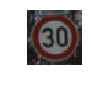

Its correspondent label:
tensor(1)


In [11]:
inputs = None
labels = None
for i, data in enumerate(trainloader_gtsrb):
    inputs, labels = data
    if i == 10:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

# GTSRB Dataset

In [ ]:
cnn_gtsrb = CNN()
if (use_gpu):
    cnn_gtsrb.cuda()
print(cnn_gtsrb)

In [ ]:
para_file_gtsrb = "./parameters/cnn_gtsrb"
load_model_gtsrb = os.path.isfile(para_file_gtsrb)
print("load_model_gtsrb = " + str(load_model_gtsrb))

In [ ]:
%%skip (not $load_model_gtsrb)
cnn_gtsrb.load_state_dict(torch.load(para_file_gtsrb))

## Optimizer

In [ ]:
import torch.optim as optim

lr_init = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_gtsrb.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training Process

In [ ]:
#%%skip $load_model_gtsrb

prev_loss = np.float("inf")
total_epoch = 50
reset(cnn_gtsrb)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_gtsrb):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_gtsrb(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

In [ ]:
%%skip $load_model_gtsrb

torch.save(cnn_gtsrb.state_dict(), para_file_gtsrb)

In [ ]:
print("Accuracy on SVHN test set (train on target): " + str(evaluate_accuracy(cnn_gtsrb, testloader_gtsrb)))

# Unsupervised Domain Adaptation

## Join Source and Target Dataset

In [ ]:
from my_dataset import ST_Dataset

In [ ]:
class ST_Dataset(torch.utils.data.Dataset):
    """Source and target dataset combination."""
    
    def __init__(self, source, target, batch_size):
        """
        Args:
            source (torch.utils.data.Dataset): Source dataset.
            target (torch.utils.data.Dataset): Target dataset.
            batch_size (int): Batch size.
        """
        small_len = min(len(source), len(target))
        large_len = max(len(source), len(target))
        small_len = batch_size * (small_len // batch_size)
        self.small_len = small_len
        self.length = small_len * (large_len // small_len) * 2
        self.batch_size = batch_size
        self.half_batch_size = batch_size // 2
        
        channel, height, width = source[0][0].size()
        
        self.images = torch.Tensor(self.length, channel, height, width)
        self.labels = torch.LongTensor(self.length)
        self.domains = torch.LongTensor(self.length)
        
        for idx in range(self.length):
            if idx // 64 % 2 == 0:
                # source
                idx_s = idx // 128 * 64 + idx % 128
                self.images[idx] = source[idx_s][0]
                self.labels[idx] = source[idx_s][1]
                self.domains[idx] = 0
            else:
                # target
                idx_t = (idx // 128 * 64 + idx % 128 - 64) % self.small_len
                self.images[idx] = target[idx_t][0]
                self.labels[idx] = target[idx_t][1]
                self.domains[idx] = 1
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.domains[idx]

In [ ]:
batch_size = 128

trainset_da = ST_Dataset(trainset_syn, trainset_svhn, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [ ]:
# randomly plot a sample from test set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 0:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

## GRL Layer

In [ ]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [ ]:
x = Variable(torch.Tensor([3]), requires_grad=True)
grl = GRL_func.apply

In [ ]:
loss = grl(x, torch.Tensor([2]))

In [ ]:
loss.backward()

In [ ]:
x.grad

In [ ]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

## Structure

![SVHN Structure](https://c1.staticflickr.com/1/907/41989310211_cb9d63bcc2_o.png)

In [ ]:
class CNN_DA(nn.Module):
    
    def __init__(self, lamda_init=0):
        super(CNN_DA, self).__init__()
        # lamda
        self.lamda = lamda_init
        # feature extractor
        self.C1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(96, 144, kernel_size=3, padding=2)
        self.C3 = nn.Conv2d(144, 256, kernel_size=5, padding=2)
        # label classifier
        self.FC1 = nn.Linear(256 * 5 * 5, 512)
        self.FC2 = nn.Linear(512, 43)
        # domain classifier
        self.GRL_layer = GRL(lamda_init)
        self.DC_FC1 = nn.Linear(256 * 5 * 5, 1024)
        self.DC_FC2 = nn.Linear(1024, 1024)
        self.DC_FC3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # M3
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # x's size is (128, 256, 5, 5)
        # flatten
        x = x.view(-1, 256 * 5 * 5)
        f = x
        # label classifier
        # FC1
        x_l = F.relu(self.FC1(x))
        # FC2
        x_l = F.softmax(self.FC2(x_l))
        # domain classifier
        # GRL
        x_d = self.GRL_layer(x)
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x_d))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.sigmoid(self.DC_FC3(x_d))
        return x_l, x_d, f, lh
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)

In [ ]:
cnn_da = CNN_DA(0)
if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

In [ ]:
para_file_da = "./parameters/cnn_syn_to_svhn"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

In [ ]:
%%skip (not $load_model_da)
cnn.load_state_dict(torch.load(para_file_da))

### Optimizer

In [ ]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

### Training process

In [ ]:
#%%skip $load_model_da

prev_loss = np.float("inf")
total_epoch = 1
# reset(cnn_da)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    p=1
    adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    for i, data in enumerate(trainloader_da):
        source_size = data[0].size()[0] // 2
        inputs, labels, domains = data
        domains = domains.to(torch.float32)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        outputs_LC, outputs_DC, _, _ = cnn_da(inputs)
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 600 == 599:    # print every 600 mini-batches
            print('[%4d] batch loss: %.3f' %
                  (i + 1, running_loss / 600))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    print(("Label classifier accuracy on SVHN test set (DA): %f\n"
           "Domain classifier accuracy on SVHN test set (DA): %f")
          %evaluate_da_accuracy(cnn_da, testloader_svhn, source=False))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        pass
    else:
        prev_loss = epoch_loss

In [ ]:
0.8795712968653965
0.894169
0.9270897357098955

In [ ]:
(0.894169-0.8795712968653965)/(0.9270897357098955-0.8795712968653965)

In [ ]:
%%skip $load_model_da

torch.save(cnn_da.state_dict(), para_file_da)

In [ ]:
def evaluate_da_accuracy(model, dataloader, source):
    correct_LC = 0
    correct_DC = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs_LC, outputs_DC, _, _ = model(inputs)
        correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
        if source:
            correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
        else:
            correct_DC += outputs_DC.data.sum().item()
        total += labels.size()[0]
    acc_LC = correct_LC / total
    acc_DC = correct_DC / total
    return acc_LC, acc_DC

In [ ]:
print(("Label classifier accuracy on SYNNUM test set (DA): %f\n"
       "Domain classifier accuracy on SYNNUM test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_syn, source=True))

In [ ]:
print(("Label classifier accuracy on SVHN test set (DA): %f\n"
       "Domain classifier accuracy on SVHN test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_svhn, source=False))

In [ ]:
from sklearn import manifold

def extract_features(model, dataloader, num=None):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        outputs = model(inputs)
        if len(outputs) == 3:
            _, f, l = outputs
        else:
            _, _, f, l = outputs
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
        if num:
            if labels.size()[0] >= num:
                break
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

def visualize_single_dataset(data, labels, perplexity=50, sample_num=None):
    total_num = labels.shape[0]
    if sample_num:
        idx = np.random.choice(total_num, sample_num, replace=False)
        data, labels = data[idx, :], labels[idx]
        total_num = sample_num
    tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    colors = ["red", "orange", "goldenrod", "yellow", "yellowgreen", "green", "teal", "blue", "violet", "purple"]
    for i in range(10):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], alpha=0.4)
    plt.axis("off")
    
def visualize_da(source, target, perplexity=50, sample_num=None, save=None):
    source_num = source.shape[0]
    target_num = target.shape[0]
    if sample_num:
        source, target = source[:sample_num, :], target[:sample_num, :]
        
    data = np.vstack((source, target))

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    plt.scatter(X[:sample_num, 0], X[:sample_num, 1], c="blue", edgecolors=None, alpha=0.4)
    plt.scatter(X[sample_num:, 0], X[sample_num:, 1], c="red", edgecolors=None, alpha=0.4)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()
    plt.clf()
    plt.close()

In [ ]:
f_syn_da, lh_syn_da, l_syn_da = extract_features(cnn_da, testloader_syn, num=1000)
f_svhn_da, lh_svhn_da, l_svhn_da = extract_features(cnn_da, testloader_svhn, num=1000)

In [ ]:
visualize_da(f_syn_da.numpy(), f_svhn_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SYNNUM_to_SVHN_features_Adapted.svg")

In [ ]:
visualize_da(lh_syn_da.numpy(), lh_svhn_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SYNNUM_to_SVHN_lasthidden_Adapted.svg")

In [ ]:
f_syn, lh_syn, l_syn = extract_features(cnn_syn, testloader_syn, num=1000)
f_svhn, lh_svhn, l_svhn = extract_features(cnn_syn, testloader_svhn, num=1000)

In [ ]:
visualize_da(f_syn.numpy(), f_svhn.numpy(), perplexity=50, sample_num=500,
             save="./pics/SYNNUM_to_SVHN_features_NonAdapted.svg")

In [ ]:
visualize_da(lh_syn.numpy(), lh_svhn.numpy(), perplexity=50, sample_num=500,
             save="./pics/SYNNUM_to_SVHN_lasthidden_NonAdapted.svg")

In [ ]:
visualize_single_dataset(lh_svhn_da.numpy(), l_svhn_da.numpy(), perplexity=50, sample_num=1000)

In [ ]:
f_syn, lh_syn, l_syn = extract_features(cnn_syn, testloader_syn, num=1000)
f_svhn, lh_svhn, l_svhn = extract_features(cnn_syn, testloader_svhn, num=1000)

In [ ]:
visualize_single_dataset(lh_svhn.numpy(), l_svhn.numpy(), perplexity=50, sample_num=1000)